**Арешин Станислав Олегович**

*Классификация отзывов об авиакомпании на основе текстового описания*

# Введение


**Цель** моего проекта: постараться охватить как можно больше материала из пройденного за 3 блока. Я хочу сначала применить к выбранным данным классические алгоритмы Машинного обучения, а затем перейти к Нейронным сетям. По результатам проделанной работы я хочу сравнить эти два подхода по различным параметрам (время обучения, время на реализацию, вычислительные ресурсы, полученная точность) и определить, в каких условиях какой подход предпочтительнее.

Для работы я выбрал данные с kaggle: https://www.kaggle.com/rakshitrk/airline-reviews. Данные представляют собой набор отзывов о полётах в различных авиакомпаниях (признак comment) с оценкой полёта по 5-ти бальной шкале (признак rating). 

В проекте решаются две задачи классификации: 

**multiclass classification** - классификация на 5 классов классическими алгоритмами и нейронными сетями.

**binary classification** - классификация на 2 класса ( 0, если < 4, 1, если 4 или 5) классическими алгоритмами и нейронными сетями.

# Подготовка данных


## Импорт библиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# загрузка данных

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/mmad_mipt/project/data/reviews.csv')
df.head()

,comment,rating,url_website,company_name,company_website,company_logo
0,"Mohammad harun, he is an awesome guy very info...",5,https://www.trustpilot.com/review/www.flydealf...,FlyDealFare.com,http://flydealfare.com?utm_medium=company_prof...,//s3-eu-west-1.amazonaws.com/tpd/logos/55a5e61...
1,"amazing guy gaurav was, so patience and kind. ...",5,https://www.trustpilot.com/review/www.flydealf...,FlyDealFare.com,http://flydealfare.com?utm_medium=company_prof...,//s3-eu-west-1.amazonaws.com/tpd/logos/55a5e61...
2,Gaurav was very knowledgeable and very helpful...,5,https://www.trustpilot.com/review/www.flydealf...,FlyDealFare.com,http://flydealfare.com?utm_medium=company_prof...,//s3-eu-west-1.amazonaws.com/tpd/logos/55a5e61...
3,I called them regarding my flight cancellation...,5,https://www.trustpilot.com/review/www.flydealf...,FlyDealFare.com,http://flydealfare.com?utm_medium=company_prof...,//s3-eu-west-1.amazonaws.com/tpd/logos/55a5e61...
4,VERY GOOD SERVICE BY GAURAV LOHAT SERVED AS SO...,4,https://www.trustpilot.com/review/www.flydealf...,FlyDealFare.com,http://flydealfare.com?utm_medium=company_prof...,//s3-eu-west-1.amazonaws.com/tpd/logos/55a5e61...


## Проверка на пропуски, удаление неинформативных признаков

Первым делом нужно проверить данные на наличие null значений и удалить строки, в которых они присутствуют

In [ ]:
# проверим на null значения 

print(len(df))

df.info()

308384
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308384 entries, 0 to 308383
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   comment          308384 non-null  object
 1   rating           308384 non-null  int64 
 2   url_website      308384 non-null  object
 3   company_name     308384 non-null  object
 4   company_website  308384 non-null  object
 5   company_logo     308384 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.1+ MB


В данных все строки заполнены корректно. Теперь избавимся от неинформативных признаков.

* url_website - ссылка на отзыв, можно удалить
* company_name - название авиакомпании, удаляем
* company_website - ссылка на сайт авиакомпании, можно удалить
* company_logo - ссылка на лого, тоже удаляем

В итоге, остаётся только признак comment - текстовое описание отзыва и целевая величина rating

Будем прогнозировать rating по comment


In [4]:
# удаление неинформативных признаков
df = df.drop(['url_website', 'company_name', 'company_website', 'company_logo'], axis = 1)

df.head()

,comment,rating
0,"Mohammad harun, he is an awesome guy very info...",5
1,"amazing guy gaurav was, so patience and kind. ...",5
2,Gaurav was very knowledgeable and very helpful...,5
3,I called them regarding my flight cancellation...,5
4,VERY GOOD SERVICE BY GAURAV LOHAT SERVED AS SO...,4


## Посмотрим на баланс целевой величины

Проверим балансировку целевой величины, используя sns.barplot

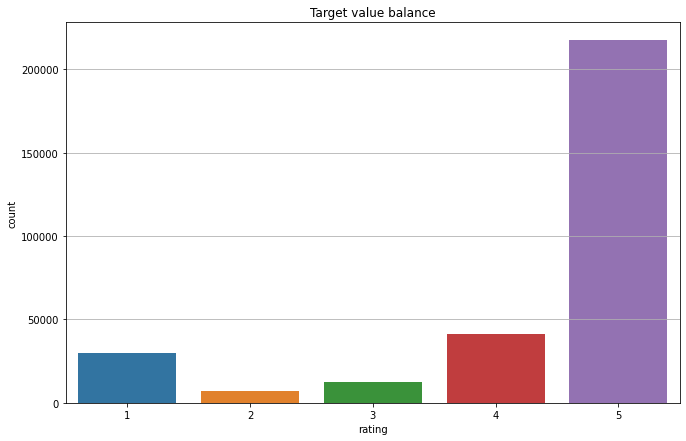

In [11]:
# проверим баланс 
balance = df.groupby('rating')['rating'].count().to_numpy()

plt.figure(figsize=[11,7])
plt.title('Target value balance')
plt.xlabel('rating')
plt.ylabel('count')
plt.grid()

sns.barplot(x = [1, 2, 3, 4, 5], y = balance)

К сожалению, очень плохой баланс целевой величины. Можно было бы обрезать данные до баланса, но тогда из 300к данных останется чуть больше 100к, то есть мы удалим 2/3 всех данных. Хотелось бы поработать со всеми данными (всё таки есть разница между 300к и 100к), поэтому оставлю баланс таким, но это определённо скажется на качестве прогноза.

## Подготовка текста

Проведём небольшую чистку текста: приведём слова к нижнему регистру, почистим от пунктуации и стоп слов.

In [ ]:
import spacy
import re

nlp = spacy.load("en")

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt)>2:
        return ' '.join(txt)

cleaned = (re.sub("[^A-Za-z]+",' ',str(row)) for row in df['comment'])

text = [cleaning(doc) for doc in nlp.pipe(cleaned, batch_size=5000)]
text[:3]

['mohammad harun awesome guy informative helpful help book flight india emergency situation finish formality thankful team rock harun',
 'amazing guy gaurav patience kind help start end go way extra information time book flydealfare website book future s agent like gaurav thank gaurav',
 'gaurav knowledgeable helpful know situation able job professionally feel pressured buy rush follow helpful']

Сохраним предобработанный текст в новый датафрейм.

In [ ]:
labales = df['rating'].copy().to_numpy()
df_res = pd.DataFrame(text, columns=['comment']) 
df_res['rating'] = labales 
df_res.head()

,comment,rating
0,mohammad harun awesome guy informative helpful...,5
1,amazing guy gaurav patience kind help start en...,5
2,gaurav knowledgeable helpful know situation ab...,5
3,call flight cancellation narrate worry polite ...,5
4,good service gaurav lohat serve soon reach tra...,4


In [ ]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308384 entries, 0 to 308383
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   comment  294523 non-null  object
 1   rating   308384 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.7+ MB


Появились null значения, возможно, некоторые строки были заполнены не словами, были битыми или написаны не на английском языке, предобработка их занулила.

Почистим новый датафрейм от null значений и сохраним его на диск для дальнейшего использования.

In [ ]:
# сохраним чистый текст
df_res = df_res.dropna()

df_res.to_csv('/content/drive/My Drive/Colab Notebooks/mmad_mipt/project/data/df.csv', index=False)


# Классические алгоритмы

Переходим к классическим алгоритмам машинного обучения.

Данные представляют собой текст. Для классических алгоритмов я выбрал представления текста с помощью TFIDF vectorizer.

Теперь давайте решим, какие алгоритмы использовать. Из классических алгоритмов для работы с представлениями текстовых данных идеально подходят алгоритмы Наивного Байеса : можно очень быстро получить хороший результат. Помимо алгоритмов Наивного Байеса, я решил потестить LogReg и LinearSVC, так как они вроде неплохо переносят большой объём данных и большое пространство признаков (по моему личному опыту)

Библиотека машинного обучения sklearn https://scikit-learn.org/stable/


## Фукнция отрисовки grid_search

Здесь реализована функция отрисовки кросс-валидации параметров модели

In [ ]:
# Функция отрисовки графиков
def grid_plot(x, y, x_label, title, y_label='accuracy'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

## Загрузим почищенный датасет

In [12]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/mmad_mipt/project/data/df.csv')
df.head()

,comment,rating
0,mohammad harun awesome guy informative helpful...,5
1,amazing guy gaurav patience kind help start en...,5
2,gaurav knowledgeable helpful know situation ab...,5
3,call flight cancellation narrate worry polite ...,5
4,good service gaurav lohat serve soon reach tra...,4


Проверим, всё ли корректно загрузилось

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294523 entries, 0 to 294522
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   comment  294523 non-null  object
 1   rating   294523 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.5+ MB


Ещё раз посмотрим на баланс, так как мы дропнули null значения полсле предобработки текста

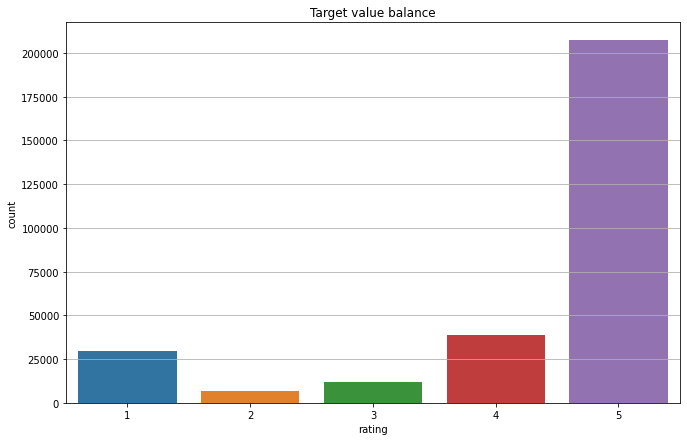

In [13]:
# проверим баланс 
balance = df.groupby('rating')['rating'].count().to_numpy()

plt.figure(figsize=[11,7])
plt.title('Target value balance')
plt.xlabel('rating')
plt.ylabel('count')
plt.grid()

sns.barplot(x = [1, 2, 3, 4, 5], y = balance)

Баланс не сильно изменился, продолжаем.

## TFIDF vectorizer

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции.

TF (term frequency — частота слова) — отношение числа вхождений некоторого слова к общему числу слов документа. Таким образом, оценивается важность слова в пределах отдельного документа.

IDF (inverse document frequency — обратная частота документа) — инверсия частоты, с которой некоторое слово встречается в документах коллекции. Учёт IDF уменьшает вес широкоупотребительных слов. Для каждого уникального слова в пределах конкретной коллекции документов существует только одно значение IDF.


In [ ]:
# выделим title отдельно

comment = df['comment'].copy()
comment

0         mohammad harun awesome guy informative helpful...
1         amazing guy gaurav patience kind help start en...
2         gaurav knowledgeable helpful know situation ab...
3         call flight cancellation narrate worry polite ...
4         good service gaurav lohat serve soon reach tra...
                                ...                        
294518    double check price place order auto jump diffe...
294519    reserved flight expect justfly website work issue
294520                                     quick easy cheap
294521                               great experience price
294522    find website extremely helpful book twice time...
Name: comment, Length: 294523, dtype: object

Создаём tf-idf представление текста.

In [ ]:
# импортируем tfidf преобразование
from sklearn.feature_extraction.text import TfidfVectorizer

# стоп слова
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# инициализировали алгоритм
vectorizer = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))

# преобразовали в матрицу tfidf 
comment_tfidf = vectorizer.fit_transform(comment.values)

# отобразим значения 

comment_tfidf[0]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


<1x1164017 sparse matrix of type '<class 'numpy.float64'>'
	with 34 stored elements in Compressed Sparse Row format>

## Multiclass Classification

Вот список алгоритмов sklearn, поддерживающих Multiclass Classification

https://scikit-learn.org/stable/modules/multiclass.html

Выделим отдельно целевую переменную

In [ ]:
y = np.array(df['rating'].copy()) # ответы
y

array([5, 5, 5, ..., 5, 5, 5])

Сдедаем train - test split в соотношении 80 на 20

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(comment_tfidf,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

### Алгоритмы Наивного Байеса 

Из алгоритмов Навиного Байеса для задачи multiclass classification с представлением td-idf подходит только алгоритм BernoulliNB

#### BernoulliNB

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html

Проведём тюнинг модели с помощью кросс-валидации с целью выявить лучшие параметры алгоритма

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import BernoulliNB

alg = BernoulliNB()

grid = {'alpha': np.array(np.linspace(0, 6, 30), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=1, n_jobs = -1)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.5min finished


({'alpha': 1.2413793103448276}, 0.7162610706279903)

Построим график кросс-валидации

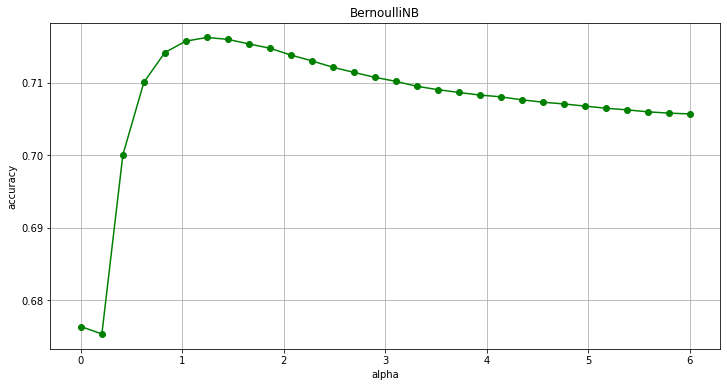

In [ ]:
grid_plot(grid['alpha'], gs.cv_results_['mean_test_score'], 'alpha', 'BernoulliNB')

Теперь используем модель с лучшими параметрами для обучения и теста

In [ ]:
%%time

from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import classification_report

clf = BernoulliNB(alpha= 1.2413793103448276)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.52      0.35      0.41      5923
           2       0.09      0.00      0.00      1318
           3       0.07      0.00      0.00      2380
           4       0.23      0.02      0.04      7812
           5       0.74      0.97      0.84     41472

    accuracy                           0.72     58905
   macro avg       0.33      0.27      0.26     58905
weighted avg       0.61      0.72      0.64     58905

CPU times: user 898 ms, sys: 23.7 ms, total: 922 ms
Wall time: 932 ms


Получили точность 72 %, модель плохо распознаёт классы 2-4, очень хорошо класс 5 (ну его больше всех) и более менее класс 1.

Кросс-валидация параметров длилась 1.5 минуты, обучение модели меньше секунды.

Переходим к следующему алгортиму

### Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Аналогично используем кросс-валидацию для тюннинга модели

In [ ]:
from sklearn.linear_model import LogisticRegression

alg = LogisticRegression()

grid = {'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.array(np.logspace(-3, 2, num = 10), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=1, n_jobs = -1)
gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 69.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVE

({'C': 0.5994842503189409, 'penalty': 'l2'}, 0.7308524794045165)

Обучаем модель с лучшими параметрами и делаем предсказания

In [ ]:
%%time

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

clf = LogisticRegression(penalty='l2' , C=0.5994842503189409)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.61      0.44      0.51      5923
           2       0.25      0.00      0.01      1318
           3       0.21      0.01      0.02      2380
           4       0.35      0.02      0.03      7812
           5       0.74      0.97      0.84     41472

    accuracy                           0.73     58905
   macro avg       0.43      0.29      0.28     58905
weighted avg       0.65      0.73      0.65     58905

CPU times: user 2min 52s, sys: 41.4 s, total: 3min 33s
Wall time: 2min 32s


Получена точность 73 %, уже лучше, чем у BernoulliNB. Всё так же плохо распознаёт классы 2-4. 

Кроме того, важно отметить, что кросс-валидация параметров длилась 69 миннут, обучение почти 3 минуты, что гораздо дольше, чем у BernoulliNB.

### Linear SVC

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

Снова начинаем с кросс-валидации для поиска лучших параметров модели

In [ ]:
# модель

from sklearn.svm import LinearSVC

alg = LinearSVC()

grid = {'C': np.array(np.linspace(0, 5, 10), dtype='float'),
        'penalty': ['l1', 'l2'],
         }

gs = GridSearchCV(alg, grid, verbose=1, n_jobs = -1)

gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 33.8min finished


({'C': 0.5555555555555556, 'penalty': 'l2'}, 0.727236458732506)

Обучаем и делаем предсказания

In [ ]:
%%time

from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report

clf =  LinearSVC(penalty = 'l2', C = 0.5555555555555556)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.59      0.46      0.52      5923
           2       0.24      0.01      0.02      1318
           3       0.28      0.02      0.03      2380
           4       0.27      0.04      0.06      7812
           5       0.75      0.96      0.84     41472

    accuracy                           0.73     58905
   macro avg       0.43      0.30      0.29     58905
weighted avg       0.64      0.73      0.66     58905

CPU times: user 24.6 s, sys: 22.8 ms, total: 24.6 s
Wall time: 24.6 s


Снова получена точность 73%, всё так же плохо определяются 2-4 классы. Но время кросс-валидации - 34 минуты, время обучения - 24.6 секунды. Однозначно, LinearSVC проигрывает по времени BernoulliNB, но он гораздо лучше, чем LogReg.



### Выводы по Multiclass Classification классическими алгоритмами

По времени однозачно выиграл BernoulliNB, по точности лучше LinearSVC и LogReg. Между LinearSVC и LogReg выбираем LinearSVC, так как он просто быстрее. По времени на реализацию алгортимы одинаковы, по требованиям к вычислительным ресурсам тоже.

Если в решаемой задаче очень важны затарты времени, то лучше использовать BernoulliNB (72).

Если же важнее 1 процент точности, то выбираем LinearSVC (73).

## Binary Classification

Для бинарной классификации выбор алгоритмов гораздо больше. Опробуем MultinomialNB, ComplementNB, а так же уже выше упомянутые BernoulliNB, LogReg и LinearSVC

### Сделаем задачу бинарной классификации

Создадим задачу бинарной классификации : если оценка < 4, то класс 0 , в противном случае класс 1.

Так же снова посмотрим на баланс целевой величины уже новой задачи.

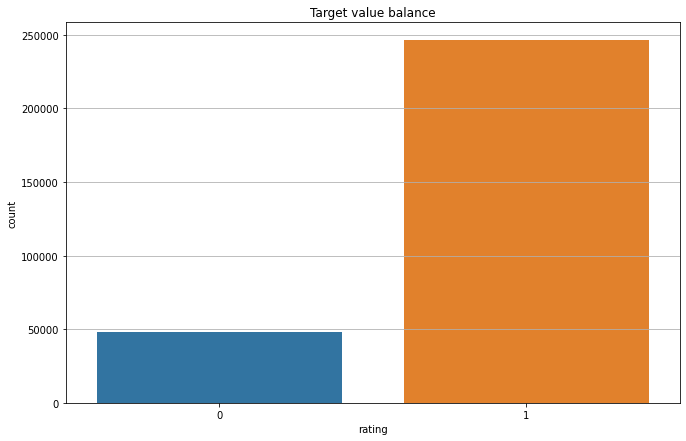

In [14]:
# проверим баланс для бинарной классификации

df_binary = df.copy()
df_binary['rating'] = df['rating'].map(lambda x: 0 if x < 4 else 1)

balance = df_binary.groupby('rating')['rating'].count().to_numpy()

plt.figure(figsize=[11,7])
plt.title('Target value balance')
plt.xlabel('rating')
plt.ylabel('count')
plt.grid()

sns.barplot(x = [0, 1], y = balance)

Ну относительно задачи классификации на 5 классов, можно сказать, что баланс улучшился, но он все равно плохой : 1/5.

Снова не будем урезать, продолжаем работу с такими данными.

Сохраним датафрейм на диск для дальнейшей работы.

In [ ]:
df_binary.to_csv('/content/drive/My Drive/Colab Notebooks/mmad_mipt/project/data/df_binary.csv', index=False)

Выделим целевую переменную.

In [ ]:
y = np.array(df_binary['rating'].copy()) # ответы
y

array([1, 1, 1, ..., 1, 1, 1])

Сделаем train-test split 80 на 20

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(comment_tfidf,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

### Алгоритмы Наивного Байеса 


#### MultinomialNB

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

Проведём тюнинг модели с помощью кросс-валидации с целью выявить лучшие параметры алгоритма

In [ ]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV

alg = MultinomialNB()

grid = {'alpha': np.array(np.linspace(0, 6, 30), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=1, n_jobs = -1)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   35.4s finished


({'alpha': 0.20689655172413793}, 0.8687961063482073)

Построим график кросс-валидации

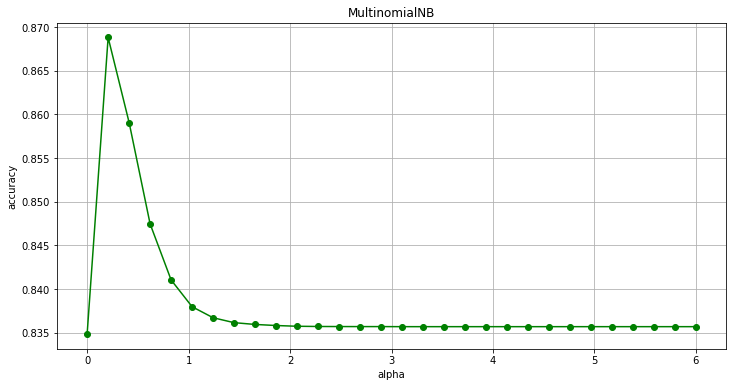

In [ ]:
grid_plot(grid['alpha'], gs.cv_results_['mean_test_score'], 'alpha', 'MultinomialNB')

Обучим модель с лучшими параметрами и сделаем предсказания

In [ ]:
%%time

clf = MultinomialNB(alpha=0.20689655172413793)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.44      0.53      9621
           1       0.90      0.95      0.92     49284

    accuracy                           0.87     58905
   macro avg       0.77      0.70      0.73     58905
weighted avg       0.86      0.87      0.86     58905

CPU times: user 407 ms, sys: 9.98 ms, total: 417 ms
Wall time: 420 ms


Построим матрицу конфузий

[[ 4281  5340]
 [ 2291 46993]]


Text(0.5, 42.0, 'Predicted value')

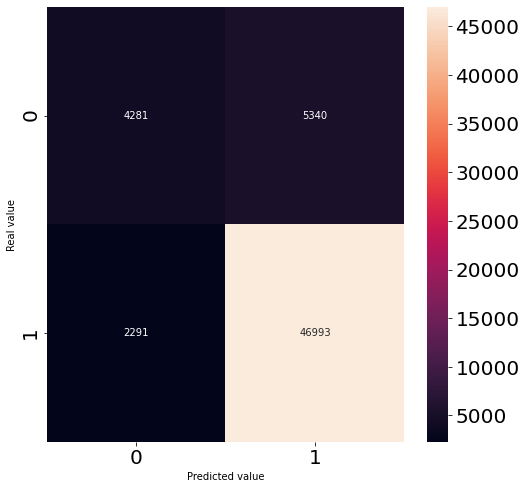

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Получили точность 87%, класс 1 очень хорошо определяется, класс 0 гораздо хуже. Алгоритм совершает больше ошибок второго рода (неверно принимает), чем первого (неверно отвергает). Очень много ошибок в распознавании класса 0 .

Время на кросс-валидацию - 35.4 секунды

Время на обучение - 420 милисекунд


#### ComplementNB

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html

Исправляет допущения MultinomialNB и больше подходит для несбалансированных данных (как раз наш случай)

Кросс валидация для поиска лучших параметров модели:

In [ ]:
from sklearn.naive_bayes import ComplementNB

alg = ComplementNB()

grid = {'alpha': np.array(np.linspace(0, 6, 30), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=1, n_jobs = -1)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   34.6s finished


({'alpha': 0.6206896551724138}, 0.8623195234742488)

Построим график кросс-валидации

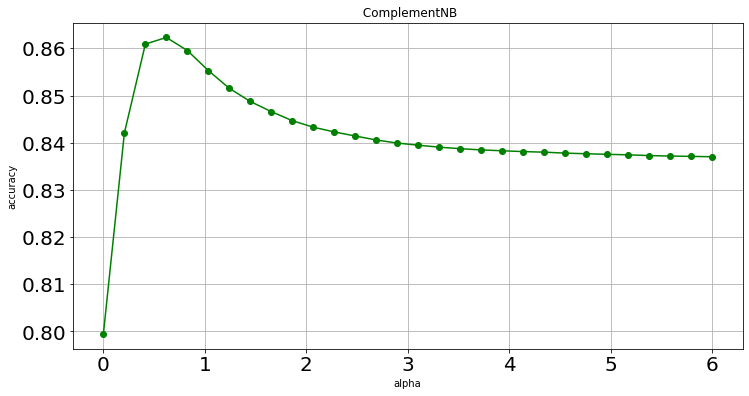

In [ ]:
grid_plot(grid['alpha'], gs.cv_results_['mean_test_score'], 'alpha', ' ComplementNB')

Обучим моедль и сделаем предсказания

In [ ]:
%%time

clf = ComplementNB(0.6206896551724138)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.61      0.43      0.51      9621
           1       0.90      0.95      0.92     49284

    accuracy                           0.86     58905
   macro avg       0.75      0.69      0.71     58905
weighted avg       0.85      0.86      0.85     58905

CPU times: user 394 ms, sys: 2.92 ms, total: 396 ms
Wall time: 399 ms


Построим матрицу конфузий

[[ 4180  5441]
 [ 2640 46644]]


Text(0.5, 42.0, 'Predicted value')

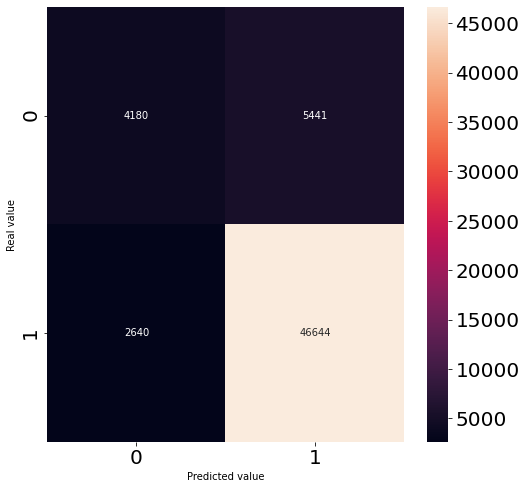

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

С точки зрения времени работы, ошибок 1 и 2 рода, распознавания классов - практически идентичны с MultinomialNB.

Но точность 86 %, на 1 % хуже, чем у MultinomialNB, так что пока оставляем лучшим MultinomialNB с 87% точности.


#### BernoulliNB

Ещё раз ссылка на алгоритм : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html

Проводим кросс-валидацию

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import BernoulliNB

alg = BernoulliNB()

grid = {'alpha': np.array(np.linspace(0, 6, 30), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=1, n_jobs = -1)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   49.6s finished


({'alpha': 1.2413793103448276}, 0.8543956744105665)

Построим график кросс-валидации

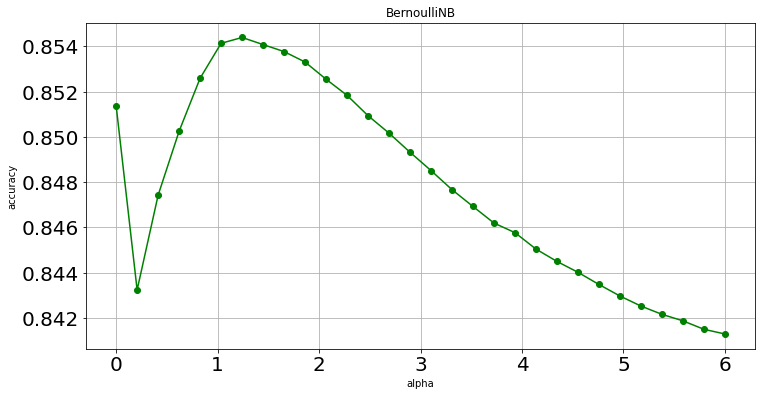

In [ ]:
grid_plot(grid['alpha'], gs.cv_results_['mean_test_score'], 'alpha', 'BernoulliNB')

Обучим модель и сделаем предсказания

In [ ]:
%%time

from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import classification_report

clf = BernoulliNB(alpha= 1.2413793103448276)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.59      0.36      0.45      9621
           1       0.88      0.95      0.92     49284

    accuracy                           0.85     58905
   macro avg       0.73      0.66      0.68     58905
weighted avg       0.84      0.85      0.84     58905

CPU times: user 539 ms, sys: 3.91 ms, total: 542 ms
Wall time: 544 ms


Построим матрицу конфузий

[[ 3490  6131]
 [ 2474 46810]]


Text(0.5, 42.0, 'Predicted value')

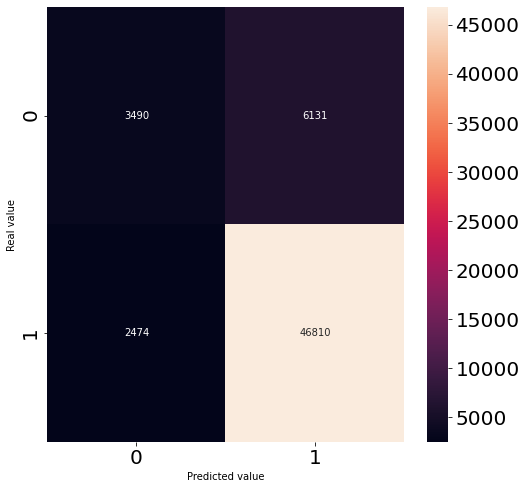

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

По точности ещё хуже, чем MultinomialNB : 85% vs 87%. Так что все ещё MultinomialNB самый лучший.

### Logistic Regression

Ещё раз ссылка на алгоритм https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Проводим кросс-валидацию

In [ ]:
from sklearn.linear_model import LogisticRegression

alg = LogisticRegression()

grid = {'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.array(np.logspace(-3, 2, num = 10), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=1, n_jobs = -1)
gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 13.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVE

({'C': 2.1544346900318843, 'penalty': 'l2'}, 0.8701924370408974)

Обучим модель и сделаем предсказания

In [ ]:
%%time

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

clf = LogisticRegression(penalty = 'l2', C = 2.1544346900318843)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.70      0.39      0.50      9621
           1       0.89      0.97      0.93     49284

    accuracy                           0.87     58905
   macro avg       0.79      0.68      0.71     58905
weighted avg       0.86      0.87      0.86     58905

CPU times: user 43 s, sys: 26.7 s, total: 1min 9s
Wall time: 35.8 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Построим матрицу конфузий

[[ 3727  5894]
 [ 1621 47663]]


Text(0.5, 42.0, 'Predicted value')

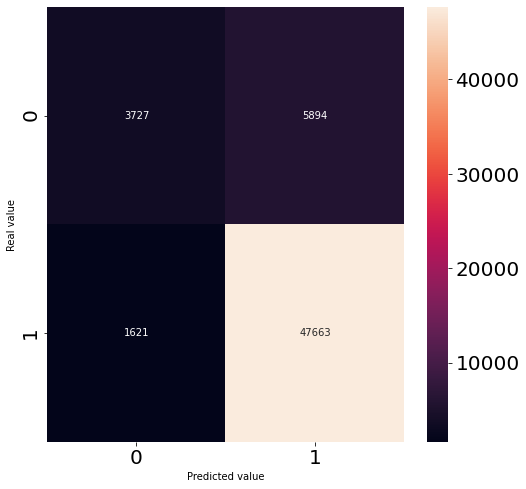

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Точность идентична MultinomialNB (87%), кол-во ошибок 1 и 2 рода практически идентичны, но LogReg серьёзно проигрывает по времени.

Всё ещё MultinomialNB невозможно обогнать.

### LinearSVC

Ещё раз ссылочка https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

Проводим кросс-валидацию

In [ ]:
# модель

from sklearn.svm import LinearSVC

alg = LinearSVC()

grid = {'C': np.array(np.linspace(0, 5, 10), dtype='float'),
        'penalty': ['l1', 'l2'],
         }

gs = GridSearchCV(alg, grid, verbose=1)

gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: b'C <= 0'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  9.4min finished


({'C': 0.5555555555555556, 'penalty': 'l2'}, 0.8693011629776617)

Обучим модель и сделаем предсказания

In [ ]:
%%time

from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report

clf =  LinearSVC(penalty = 'l2', C = 0.5555555555555556)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.69      0.38      0.49      9621
           1       0.89      0.97      0.93     49284

    accuracy                           0.87     58905
   macro avg       0.79      0.67      0.71     58905
weighted avg       0.86      0.87      0.85     58905

CPU times: user 5.47 s, sys: 2.17 ms, total: 5.47 s
Wall time: 5.52 s


Построим матрицу конфузий

[[ 3689  5932]
 [ 1696 47588]]


Text(0.5, 42.0, 'Predicted value')

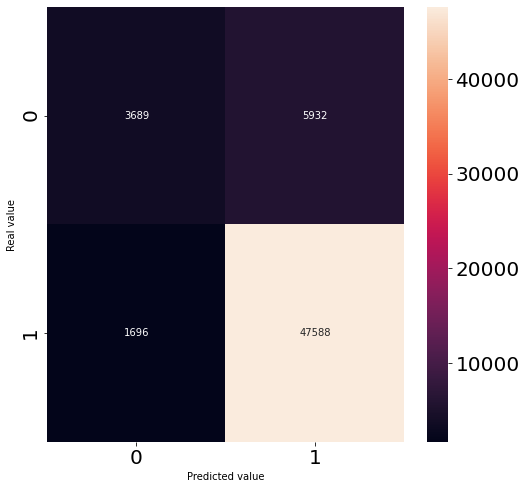

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib

fig = plt.figure(figsize=(8,8))
nn_mtx = confusion_matrix(y_test, preds)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Аналогично LogReg, точность такая же, как у MultinomialNB (87%), но проигрывает по времени.

### Выводы по Binary Classification классическими алгоритмами

По всем параметрам самым лучшим алгоритмом для моих данных и задачи бинарной классификации оказался алгоритм MultinomialNB с 87 % точности.

По сравнению с задачей Multiclass Classification, результаты по точности гораздо лучше, так как меньше классов на определение, чуть лучше баланс данных.

## Выводы по классическим алгоритмам

Подведём итог.

* Для задачи Multiclass Classification лучшим по точности оказался LinearSVC (73%), чуть проиграл по точности, но гораздо лучше по времени BernoulliNB (72%)

* Для задачи Binary Classification лучшим и по точности и по времени работы оказался  MultinomialNB (87%)

С этими тремя алгоритмами будем сравнивать нейронные сети. Так кто же лучше???

# Нейронные сети

Переходим к глубокму обучению. Для классификации текста я выбрал 2 архитектуры: 

1) LSTM, так как я с ней уже знаком, в принципе обычно она давала хорошие результаты классификации.

2) BERT, своего рода монстр в сфере NLP, очень интересно, какие результаты будут получены такой сложной архитектурой.

Аналогично классическим алгоритмам, я буду решать 2 задачи классификации - бинарной и многоклассовой двумя архитектурами

В качестве представления текста для нейронных сетей для LSTM выбран w2v, для BERT свой формат.

Посмотрим, смогут ли нейронные сети превзойти лучшие из классических алгоритмов на моих данных.

Библиотека глубокого обучения pytorch https://pytorch.org/

## Импорт библиотек

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!nvidia-smi

Tue Oct  6 15:13:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F

import gensim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Multiclass classification

### Подготовка целевой величичны

Сначала преобразуем классы из 1-5 в 0-4 для корректной работы нейронных сетей

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/mmad_mipt/project/data/df.csv')

df.head()

,comment,rating
0,mohammad harun awesome guy informative helpful...,5
1,amazing guy gaurav patience kind help start en...,5
2,gaurav knowledgeable helpful know situation ab...,5
3,call flight cancellation narrate worry polite ...,5
4,good service gaurav lohat serve soon reach tra...,4


In [ ]:
df['rating'] = df['rating'].map(lambda x: 0 if x == 1 else (1 if x == 2 else (2 if x == 3 else (3 if x == 4 else 4))))

df.head()

,comment,rating
0,mohammad harun awesome guy informative helpful...,4
1,amazing guy gaurav patience kind help start en...,4
2,gaurav knowledgeable helpful know situation ab...,4
3,call flight cancellation narrate worry polite ...,4
4,good service gaurav lohat serve soon reach tra...,3


Сохраним новый датасет на диск

In [ ]:
df.to_csv('/content/drive/My Drive/Colab Notebooks/mmad_mipt/project/data/df_nn.csv', index=False)

### LSTM

Долгая краткосрочная память (Long short-term memory; LSTM) – особая разновидность архитектуры рекуррентных нейронных сетей, способная к обучению долговременным зависимостям. 

![img2](https://miro.medium.com/max/6176/1*o9R4WZZulh7-vtfUPQsEjQ.png)

C - cell state, состояние ячейки, h - output, y - predicted by softmax or sigmoid

Cell Gate -> Forget Gate -> Input Gate -> Output Gate

#### Функция обучения LSTM для многоклассовой классификации

Вот тут я написал функцию для обучения lstm сети

In [ ]:
# функция обучения 
from tqdm import tqdm

def fit(epochs, model, loss_f, optimizer, train, test ,scheduler = None):

    train_losses = []
    valid_losses = []

    for epoch in tqdm(range(epochs)):

        train_loss = 0.0
        valid_loss = 0.0

        # меняем шаг оптимизатора
        if scheduler != None:
            scheduler.step()
            print('lr =', scheduler.get_lr())

        # тренировка модели
        for batch in iter(train):
            model.train()

            # перенесём данные на gpu
            X_batch = batch.comment.cuda()
            y_batch = batch.rating.cuda()
            y_batch = y_batch.to(torch.long)

            # обнуление градиентов
            optimizer.zero_grad()

            # прямой проход
            y_pred = model.forward(X_batch)

            # batch-loss
            loss = loss_f(y_pred, y_batch)    

            # обратный проход
            loss.backward()
            
            # оптимизируем
            optimizer.step()

            # обновялем training-loss
            train_loss += loss.item() * y_batch.size(0)

        # валидация 
        for batch in iter(test):
            model.eval()

            # перенесём данные на gpu
            X_batch = batch.comment.cuda()
            y_batch = batch.rating.cuda()
            y_batch = y_batch.to(torch.long)
            # прямой проход
            y_pred = model.forward(X_batch)

            # batch-loss
            loss = loss_f(y_pred, y_batch)  

            # обновляем validation-loss 
            valid_loss += loss.item() * y_batch.size(0)

        # считаем средние потери
        train_loss = train_loss/(len(train) * 16) # 16 - batch_size
        valid_loss = valid_loss/(len(test) * 16) # 16 - batch_size
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # статистика по эпохам
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    print('Finish!')
    return model, train_losses, valid_losses

#### Загрузка данных в torch

Загрузим данные, используя torchtext.data.TabularDataset из сохранённого ранее csv файла df_nn.csv

In [ ]:
import nltk
import torchtext
nltk.download('punkt')

text_data = torchtext.data.Field(tokenize=nltk.word_tokenize, lower=True, batch_first=True)
y = torchtext.data.Field(sequential=False, is_target=True, use_vocab=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# загрузка данных в торч

data = torchtext.data.TabularDataset(path='/content/drive/My Drive/Colab Notebooks/mmad_mipt/project/data/df_nn.csv', format='csv', 
                                     fields={
                                         'comment': ('comment', text_data),
                                         'rating': ('rating', y)
                                     })

#### Загрузка предобученного w2v и представление текста.

Word2vec — общее название для совокупности моделей на основе искусственных нейронных сетей, предназначенных для получения векторных представлений слов на естественном языке.

Работа программы осуществляется следующим образом: word2vec принимает большой текстовый корпус в качестве входных данных и сопоставляет каждому слову вектор, выдавая координаты слов на выходе. Сначала он генерирует словарь корпуса, а затем вычисляет векторное представление слов, «обучаясь» на входных текстах. Векторное представление основывается на контекстной близости: слова, встречающиеся в тексте рядом с одинаковыми словами (а следовательно, имеющие схожий смысл), будут иметь близкие (по косинусному расстоянию) векторы. Полученные векторные представления слов могут быть использованы для обработки естественного языка и машинного обучения.




Скачаем и разархивируем обученный w2v

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-10-06 12:59:13--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip.2’

wiki-news-300d-1M.v 100%[===================>] 650.22M  62.2MB/s    in 13s     

2020-10-06 12:59:27 (48.5 MB/s) - ‘wiki-news-300d-1M.vec.zip.2’ saved [681808098/681808098]



In [ ]:
!unzip '/content/wiki-news-300d-1M.vec.zip' -d '/content/'

Archive:  /content/wiki-news-300d-1M.vec.zip
replace /content/wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/wiki-news-300d-1M.vec  


Создадим словарь из слов исходного текста

In [ ]:
text_data.build_vocab(data)

Загрузим векторы слов из предобученного w2v

In [ ]:
text_data.vocab.load_vectors(torchtext.vocab.Vectors('/content/wiki-news-300d-1M.vec'))

In [ ]:
text_data.vocab.vectors.shape

torch.Size([56475, 300])

#### Train - test split и Bucket Iterators

Разделим данные на train и test в сооношении 80 на 20

In [ ]:
train, test = data.split(split_ratio= 0.8)

In [ ]:
len(train), len(test)

(235618, 58905)

Создадим BucketIterator'ы с размером батча 16, чтобы можно было итерироваться по батчам во время обучения и теста модели

In [ ]:
batch_size = 16
train_i = torchtext.data.BucketIterator(dataset=train,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        sort = False,
                                        train =True)


test_i = torchtext.data.BucketIterator(dataset=test,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        sort = False,
                                        train = False)

#### Модель

Реализация LSTM сети : 

На вход подаём wv2 эмбединги текста, pad_idx, процент dropout и размер скрытого слоя lstm

In [ ]:
class lstm_multi(nn.Module):

    def __init__(self, w2v, padding_inx, dropout, hidden_size):

        super(lstm_multi, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(w2v)
        self.embedding.padding_inx = padding_inx

        self.embedding.weight.requires_grad = True

        self.dropout = nn.Dropout(p = dropout)

        self.lstm = nn.LSTM(input_size = self.embedding.embedding_dim,
                            hidden_size = hidden_size,
                            num_layers = 2,
                            dropout = dropout,
                            bidirectional = True)
        
        self.label = nn.Linear(hidden_size*2*2, 5)

    def forward(self, sentence):

        x = self.embedding(sentence)
        x = torch.transpose(x, dim0 = 1, dim1 = 0)

        out, (hidden, c) = self.lstm(x)

        x = self.dropout(torch.cat([c[i,:,:] for i in range(c.shape[0])], dim=1))

        x = self.label(x)
    

        return F.log_softmax(x)

#### Обучение и тест модели v1

Инициализируем и отобразим модель

In [ ]:
model = lstm_multi(text_data.vocab.vectors, text_data.vocab.stoi[text_data.pad_token], dropout = 0.2, hidden_size=128).cuda()

print(model)

lstm_multi(
  (embedding): Embedding(56475, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2, bidirectional=True)
  (label): Linear(in_features=512, out_features=5, bias=True)
)


В качестве оптимизатора я буду использовать Adam, так как он хорошо себя зарекомендовал

В качестве loss функции я буду использовать CrossEntropyLoss, так как задача multiclass classification

In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

Обучим модель на 5 эпох

In [ ]:
#  тренировка модели 

model, train_losses, valid_losses = fit(5, model, loss, optimizer, train_i, test_i)

 20%|██        | 1/5 [04:27<17:48, 267.01s/it]

Epoch: 0 	Training Loss: 0.819854 	Validation Loss: 0.800205


 40%|████      | 2/5 [08:56<13:22, 267.63s/it]

Epoch: 1 	Training Loss: 0.773990 	Validation Loss: 0.809121


 60%|██████    | 3/5 [13:25<08:56, 268.24s/it]

Epoch: 2 	Training Loss: 0.719106 	Validation Loss: 0.840215


 80%|████████  | 4/5 [17:57<04:29, 269.36s/it]

Epoch: 3 	Training Loss: 0.667953 	Validation Loss: 0.894172


100%|██████████| 5/5 [22:28<00:00, 269.80s/it]

Epoch: 4 	Training Loss: 0.624739 	Validation Loss: 0.964409
Finish!


Протестируем обученную модель на тестовой выборке

In [ ]:
# посмотрим accuracy на тесте 

with torch.no_grad():
    correct = 0
    total = 0

    for batch in iter(test_i):

        # перенесём данные на gpu
        x = batch.comment.cuda()
        y = batch.rating.cuda()
        y = y.to(torch.long)
        # прямой проход
        preds = model(x)

        _, predicted = torch.max(preds.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy of the model: 70.3828197945845 %


Отобразим  график обучения

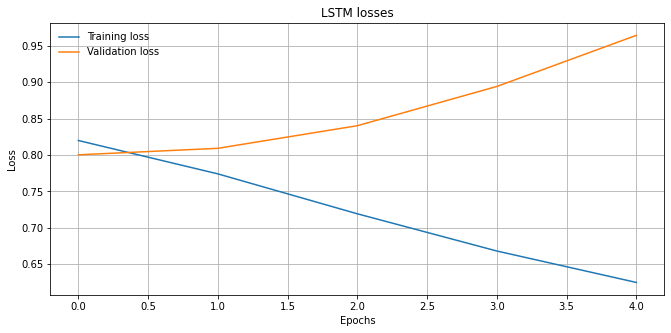

In [ ]:
plt.figure(figsize=[11,5])
plt.title('LSTM losses')
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.grid()

По графику видно, что моедль переобучается очень быстро, снизим кол-во эпох до 3 и обучим ещё раз.

Кроме того, точность прогноза, которая была получена проигрывает всем классическим алгоритмам.

#### Обучение и тест модели v2

Инициализируем и отобразим модель заново

In [ ]:
model = lstm_multi(text_data.vocab.vectors, text_data.vocab.stoi[text_data.pad_token], dropout = 0.2, hidden_size=128).cuda()

print(model)

lstm_multi(
  (embedding): Embedding(56475, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2, bidirectional=True)
  (label): Linear(in_features=512, out_features=5, bias=True)
)


Инициализируем оптимизатор и функцию потерь

In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

Обучим модель на 3 эпохи

In [ ]:
#  тренировка модели 

model, train_losses, valid_losses = fit(3, model, loss, optimizer, train_i, test_i)

 33%|███▎      | 1/3 [04:29<08:58, 269.22s/it]

Epoch: 0 	Training Loss: 0.819999 	Validation Loss: 0.802566


 67%|██████▋   | 2/3 [08:59<04:29, 269.41s/it]

Epoch: 1 	Training Loss: 0.774987 	Validation Loss: 0.803778


100%|██████████| 3/3 [13:29<00:00, 269.74s/it]

Epoch: 2 	Training Loss: 0.720918 	Validation Loss: 0.836850
Finish!


Протестируем обученную модель на тестовой выборке

In [ ]:
# посмотрим accuracy на тесте 

with torch.no_grad():
    correct = 0
    total = 0

    for batch in iter(test_i):

        # перенесём данные на gpu
        x = batch.comment.cuda()
        y = batch.rating.cuda()
        y = y.to(torch.long)
        # прямой проход
        preds = model(x)

        _, predicted = torch.max(preds.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy of the model: 72.7527374586198 %


Построим график обучения

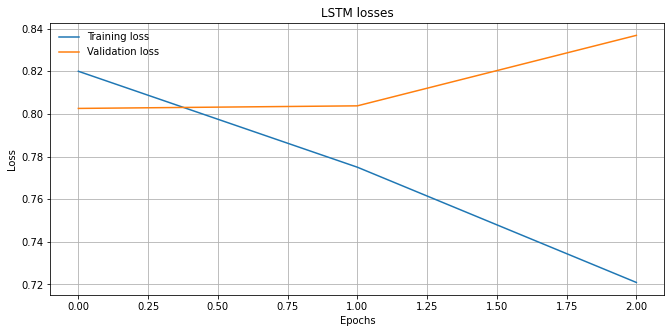

In [ ]:
plt.figure(figsize=[11,5])
plt.title('LSTM losses')
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.grid()

Точность уже лучше, сравнима с BernoulliNB (72) , но всё ещё проигрывает LinearSVC (73) и LogReg (73).

Кроме того снова на графиках видно переобучение после 1 эпохи. Снизим кол-во эпох до 1 и обучим ещё раз.

#### Обучение и тест модели v3

Инициализируем и отобразим модель в последний раз

In [ ]:
model = lstm_multi(text_data.vocab.vectors, text_data.vocab.stoi[text_data.pad_token], dropout = 0.2, hidden_size=128).cuda()

print(model)

lstm_multi(
  (embedding): Embedding(56475, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2, bidirectional=True)
  (label): Linear(in_features=512, out_features=5, bias=True)
)


Оптимизатор и функция потерь

In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

Обучим модель на 1 эпоху

In [ ]:
#  тренировка модели 

model, train_losses, valid_losses = fit(1, model, loss, optimizer, train_i, test_i)

100%|██████████| 1/1 [04:30<00:00, 270.73s/it]

Epoch: 0 	Training Loss: 0.819848 	Validation Loss: 0.802897
Finish!


Протестируем модель

In [ ]:
# посмотрим accuracy на тесте 

with torch.no_grad():
    correct = 0
    total = 0

    for batch in iter(test_i):

        # перенесём данные на gpu
        x = batch.comment.cuda()
        y = batch.rating.cuda()
        y = y.to(torch.long)
        # прямой проход
        preds = model(x)

        _, predicted = torch.max(preds.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy of the model: 73.38935574229691 %


Получили точность лучше, чем у BernoulliNB (72), такую же, как у LogReg(73) и LinearSVC(73)

Ура!!! Но стоило ли оно того ????

Время на реализацию сетки и отладку гораздо больше. 

Время на тюнинг порядка 40 минут. На обучение 1 эпохи 4 минуты, что опять же в несколько раз больше, чем LinearSVC

### BERT

BERT — это нейронная сеть, основанная на методе предварительной подготовки контекстных представлений слов, то есть использует двунаправленную модель языка, а также позволяет анализировать целые предложения. В этом случае, учитываются слова, которые идут после данного и через тоже. Этот метод позволяет получать с большим отрывом state-of-the-art результаты в широком спектре задач обработки естественного языка (NLP), но требует больших вычислительных мощностей.

Не будем слишком углубляться в архитектуру, вот забавная картинка.
![img2](https://habrastorage.org/webt/ee/lg/99/eelg99xutp6h7oztqyyz3hv-5e4.png)

#### Подготовка данных для BERT

Загрузим датасет

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/mmad_mipt/project/data/df_nn.csv')

df.head()

,comment,rating
0,mohammad harun awesome guy informative helpful...,4
1,amazing guy gaurav patience kind help start en...,4
2,gaurav knowledgeable helpful know situation ab...,4
3,call flight cancellation narrate worry polite ...,4
4,good service gaurav lohat serve soon reach tra...,3


Добавляем специальные токены [CLS] и [SEP] в начало и конец предложения.

In [ ]:
sentences = df['comment'].values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

rating = df['rating'].values

In [ ]:
print(sentences[0])

[CLS] mohammad harun awesome guy informative helpful help book flight india emergency situation finish formality thankful team rock harun [SEP]


#### Train-test split

Сделаем train-test split в соотношении 80 на 20

In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, rating, test_size=0.2)

In [ ]:
len(train_gt), len(test_gt)

(235618, 58905)

#### Bert Tokenizer

Импортируем токенизатор для BERT'а, который превратит тексты в набор токенов, соответствующих тем, что встречаются в словаре предобученной модели.

In [ ]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

['[CLS]', 'sky', '##pic', '##ker', 'booking', 'm', 'totally', 'satisfy', 'thank', 'lot', '[SEP]']


#### Inputs

Подготовим формат входных данных 

BERT'у нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=256,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (709 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (789 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Делим данные на train и val

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.2
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.2
)

Преобразуем данные в pytorch тензоры:

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels

tensor([4, 0, 4,  ..., 0, 4, 4])

#### Dataloaders

Создадим torch.utils.data.TensorDataset и сделаем DataLoaders для обучения и предсказания сети

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

#### Загрузка предобученного BERT'a

Из библиотеки pytorch_transformers импортируем предобученный BERT

In [ ]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5).cuda()

print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Обучение и тест модели

Здадим параметры оптимизатора 

Здесь оптимизатор с регуляризацией весов AdamW

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)


Обучим модель

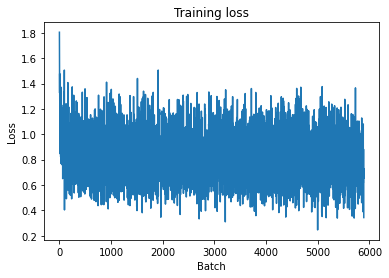

Loss на обучающей выборке: 0.81823
CPU times: user 1h 5min 33s, sys: 30min 27s, total: 1h 36min 1s
Wall time: 1h 36min 20s


In [ ]:
%%time

from IPython.display import clear_output
from sklearn.metrics import accuracy_score

train_loss_set = []
train_loss = 0

model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.cuda() for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
   
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


Сделаем предсказания

In [ ]:
%%time

model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.cuda() for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

   
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.hstack(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Test Accuracy of the model: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Test Accuracy of the model: 73.32%
CPU times: user 4min 5s, sys: 2min 36s, total: 6min 42s
Wall time: 6min 42s


Полученная точность BERT сравнима с LSTM(73%) и с LinearSVC(73%), LogReg(73%)

Так как BERT уже реализован и предобучен, на реализацию затраты такие же, как у классических, ну может немного больше, так как нужно написать функцию обучения и валидации и подготовить данные в формат для BERT

На обучение 1 эпохи ушло 1 час 36 минут, на тест 6 минту, что проигрывает и LSTM и тем более LinearSVC

Плюс нужна хорошая GPU

### Выводы по Multiclass Classification классическими алгоритмами

Очевидно, BERT хоть и массивная архитектура, но он проиграл LSTM по времени и не обогнал по точности, у обеих архитектур 73%.

Кроме того обе эти архитектуры проиграли по времени LinearSVC и опять же не обогнали по точности.

Ну что, победа классических алгоритмов?

## Binary classification

### LSTM

Немного теории можно посмотреть в блоке MultiClass Classification

#### Функция обучения LSTM для бинарной классификации

Вот тут уже другая функция для обучения бинарной lstm

In [ ]:
# функция обучения 
from tqdm import tqdm

def fit_binary(epochs, model, loss_f, optimizer, train, test ,scheduler = None):

    train_losses = []
    valid_losses = []

    for epoch in tqdm(range(epochs)):

        train_loss = 0.0
        valid_loss = 0.0

        # меняем шаг оптимизатора
        if scheduler != None:
            scheduler.step()
            print('lr =', scheduler.get_lr())

        # тренировка модели
        for batch in iter(train):
            model.train()

            # перенесём данные на gpu
            X_batch = batch.comment.cuda()
            y_batch = batch.rating.type(torch.Tensor).cuda()

            # обнуление градиентов
            optimizer.zero_grad()

            # прямой проход
            y_pred = model.forward(X_batch).view(-1)

            # batch-loss
            loss = loss_f(y_pred, y_batch)    

            # обратный проход
            loss.backward()
            
            # оптимизируем
            optimizer.step()

            # обновялем training-loss
            train_loss += loss.item() * y_batch.size(0)

        # валидация 
        for batch in iter(test):
            model.eval()

            # перенесём данные на gpu
            X_batch = batch.comment.cuda()
            y_batch = batch.rating.type(torch.Tensor).cuda()
            # прямой проход
            y_pred = model.forward(X_batch).view(-1)

            # batch-loss
            loss = loss_f(y_pred, y_batch)  

            # обновляем validation-loss 
            valid_loss += loss.item() * y_batch.size(0)

        # считаем средние потери
        train_loss = train_loss/(len(train) * 16) # 16 - batch_size
        valid_loss = valid_loss/(len(test) * 16) # 16 - batch_size
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # статистика по эпохам
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    print('Finish!')
    return model, train_losses, valid_losses

#### Загурзка данных в torch

Аналогично загрузим данные, используя torchtext.data.TabularDataset из сохранённого ранее csv файла df_nn.csv

In [ ]:
import nltk
import torchtext
nltk.download('punkt')

text_data = torchtext.data.Field(tokenize=nltk.word_tokenize, lower=True, batch_first=True)
y = torchtext.data.Field(sequential=False, is_target=True, use_vocab=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# загрузка данных в торч

data = torchtext.data.TabularDataset(path='/content/drive/My Drive/Colab Notebooks/mmad_mipt/project/data/df_binary.csv', format='csv', 
                                     fields={
                                         'comment': ('comment', text_data),
                                         'rating': ('rating', y)
                                     })

#### Загрузка предобученного w2v и представление текста.


Всё те же действия с тем же w2v представлением

In [ ]:
text_data.build_vocab(data)

In [ ]:
text_data.vocab.load_vectors(torchtext.vocab.Vectors('/content/wiki-news-300d-1M.vec'))

In [ ]:
text_data.vocab.vectors.shape

torch.Size([56475, 300])

#### Train-test split и Bucket Iterators

Разделим данные на train и test в сооношении 80 на 20

In [ ]:
train, test = data.split(split_ratio= 0.8)

In [ ]:
len(train), len(test)

(235618, 58905)

Создадим BucketIterator'ы с размером батча 16, чтобы можно было итерироваться по батчам во время обучения и теста модели

In [ ]:
batch_size = 16
train_i = torchtext.data.BucketIterator(dataset=train,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        sort = False,
                                        train =True)


test_i = torchtext.data.BucketIterator(dataset=test,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        sort = False,
                                        train = False)

#### Модель

Реализация LSTM сети : 

На вход подаём wv2 эмбединги текста, pad_idx, процент dropout и размер скрытого слоя lstm

Единственное отличие, в полседнем слое другой output

In [ ]:
class lstm_binary(nn.Module):

    def __init__(self, w2v, padding_inx, dropout, hidden_size):

        super(lstm_binary, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(w2v)
        self.embedding.padding_inx = padding_inx

        self.embedding.weight.requires_grad = True

        self.dropout = nn.Dropout(p = dropout)

        self.lstm = nn.LSTM(input_size = self.embedding.embedding_dim,
                            hidden_size = hidden_size,
                            num_layers = 2,
                            dropout = dropout,
                            bidirectional = True)
        
        self.label = nn.Linear(hidden_size*2*2, 1)

    def forward(self, sentence):

        x = self.embedding(sentence)
        x = torch.transpose(x, dim0 = 1, dim1 = 0)

        out, (hidden, c) = self.lstm(x)

        x = self.dropout(torch.cat([c[i,:,:] for i in range(c.shape[0])], dim=1))

        x = self.label(x)
    

        return x

#### Обучение и тест модели v1

Инициализируем и отобразим модель

In [ ]:
model = lstm_binary(text_data.vocab.vectors, text_data.vocab.stoi[text_data.pad_token], dropout = 0.2, hidden_size=128).cuda()

print(model)

lstm_binary(
  (embedding): Embedding(56475, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2, bidirectional=True)
  (label): Linear(in_features=512, out_features=1, bias=True)
)


В качестве оптимизатора я опять же буду использовать Adam.

В качестве loss функции я буду использовать BCEWithLogitsLoss, так как задача binary classification

In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.BCEWithLogitsLoss()

Обучим модель на 3 эпохи

In [ ]:
#  тренировка модели 

model, train_losses, valid_losses = fit_binary(3, model, loss, optimizer, train_i, test_i)


 33%|███▎      | 1/3 [04:28<08:57, 268.63s/it]

Epoch: 0 	Training Loss: 0.333042 	Validation Loss: 0.321725



 67%|██████▋   | 2/3 [08:57<04:28, 268.85s/it]

Epoch: 1 	Training Loss: 0.308129 	Validation Loss: 0.325633



100%|██████████| 3/3 [13:27<00:00, 269.23s/it]

Epoch: 2 	Training Loss: 0.281625 	Validation Loss: 0.339887
Finish!


Протестируем обученную модель на тестовой выборке

In [ ]:
model.eval()

real = []
preds = []

for batch in iter(test_i):
    x = batch.comment.cuda()
    
    real += batch.rating.data.numpy().tolist()
    preds += torch.sigmoid(model.forward(x).view(-1)).cpu().data.numpy().tolist()

In [ ]:
from sklearn.metrics import  classification_report

print(classification_report(real, np.round(np.array(preds))))

              precision    recall  f1-score   support

           0       0.66      0.39      0.49      9645
           1       0.89      0.96      0.92     49260

    accuracy                           0.87     58905
   macro avg       0.77      0.68      0.71     58905
weighted avg       0.85      0.87      0.85     58905



Отобразим график обучения

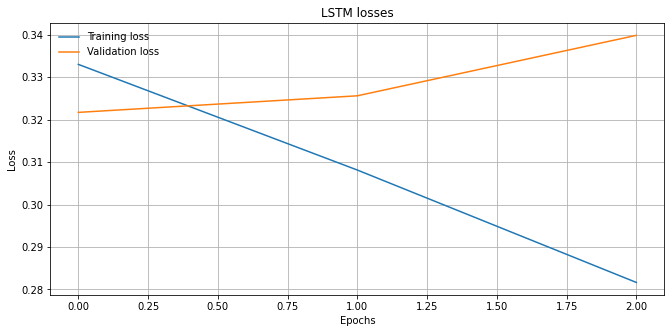

In [ ]:
plt.figure(figsize=[11,5])
plt.title('LSTM losses')
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.grid()

Снова на графиках видим переобучение после 1 эпохи.

Но точность модели сравнима с лучшими из классических алгоритмов: MultinomialNB(87), LogReg(87), LinearSVC(87). Значит, можно получить лучше!

Обучим модель на 1 эпоху.

#### Обучение и тест модели v2

Инициализируем и отобразим модель уже теперь точно в последний раз

In [ ]:
model = lstm_binary(text_data.vocab.vectors, text_data.vocab.stoi[text_data.pad_token], dropout = 0.2, hidden_size=128).cuda()

print(model)

lstm_binary(
  (embedding): Embedding(56475, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2, bidirectional=True)
  (label): Linear(in_features=512, out_features=1, bias=True)
)


Оптимизатор и функция потерь

In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.BCEWithLogitsLoss()

Обучим модель на 1 эпоху

In [ ]:
#  тренировка модели 

model, train_losses, valid_losses = fit_binary(1, model, loss, optimizer, train_i, test_i)

100%|██████████| 1/1 [04:31<00:00, 271.22s/it]

Epoch: 0 	Training Loss: 0.334007 	Validation Loss: 0.327148
Finish!


Тест модели

In [ ]:
model.eval()

real = []
preds = []

for batch in iter(test_i):
    x = batch.comment.cuda()
    
    real += batch.rating.data.numpy().tolist()
    preds += torch.sigmoid(model.forward(x).view(-1)).cpu().data.numpy().tolist()

In [ ]:
from sklearn.metrics import  classification_report

print(classification_report(real, np.round(np.array(preds))))

              precision    recall  f1-score   support

           0       0.75      0.29      0.42      9604
           1       0.88      0.98      0.93     49301

    accuracy                           0.87     58905
   macro avg       0.81      0.63      0.67     58905
weighted avg       0.86      0.87      0.84     58905



Увы, получили такую же точность, как у MultinomialNB (87%).

При этом на реализацию и отладку ушло гораздо больше времени, не говоря уже о тюнинге и обучении, по сравнению с MultinomialNB.

Пока в моей задаче классические алгортимы непобедимы. Но может BERT всё исправит?

### BERT

Немного теории по BERT можно посмотреть в разделе Multiclass Classification

#### Подготовка данных для BERT

Загрузка датасета

In [ ]:
df_binary = pd.read_csv('/content/drive/My Drive/Colab Notebooks/mmad_mipt/project/data/df_binary.csv')

df_binary.head()

,comment,rating
0,mohammad harun awesome guy informative helpful...,1
1,amazing guy gaurav patience kind help start en...,1
2,gaurav knowledgeable helpful know situation ab...,1
3,call flight cancellation narrate worry polite ...,1
4,good service gaurav lohat serve soon reach tra...,1


Добавляем специальные токены [CLS] и [SEP] в начало и конец предложения.

In [ ]:
sentences = df_binary['comment'].values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

rating = df_binary['rating'].values

In [ ]:
print(sentences[0])

[CLS] mohammad harun awesome guy informative helpful help book flight india emergency situation finish formality thankful team rock harun [SEP]


#### Train-test split

Сделаем train-test split в соотношении 80 на 20

In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, rating, test_size=0.2)

In [ ]:
len(train_gt), len(test_gt)

(235618, 58905)

#### Bert Tokenizer

Аналогично импортируем токенизатор для BERT'а, который превратит тексты в набор токенов, соответствующих тем, что встречаются в словаре предобученной модели.

In [ ]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 1229741.47B/s]


['[CLS]', 'book', 'cruise', 'hotel', 'flight', 'reservation', 'online', 'book', '##it', 'com', 'easy', 'quick', 'sure', 'look', 'future', 'vacation', '[SEP]']


#### Inputs

Подготовим формат входных данных 

BERT'у нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (699 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (713 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (679 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Делим данные на train и val

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.2
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.2
)

Преобразуем данные в pytorch тензоры:

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels

tensor([1, 1, 1,  ..., 1, 1, 1])

#### Dataloaders

Создадим torch.utils.data.TensorDataset и сделаем DataLoaders для обучения и предсказания сети

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

#### Загрузка предобученного BERT'a

Из библиотеки pytorch_transformers импортируем предобученный BERT

In [ ]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).cuda()

print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Обучение и тест модели

Здадим параметры оптимизатора 

Здесь оптимизатор с регуляризацией весов AdamW

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)


Обучим сеть

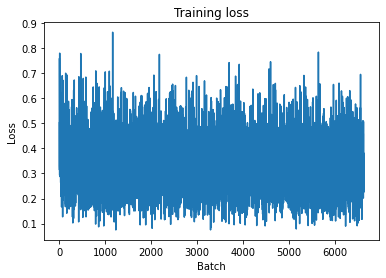

Loss на обучающей выборке: 0.33114
CPU times: user 41min 16s, sys: 12min 29s, total: 53min 45s
Wall time: 53min 58s


In [ ]:
%%time

from IPython.display import clear_output
from sklearn.metrics import accuracy_score

train_loss_set = []
train_loss = 0

model.train()

for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.cuda() for t in batch)

    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

Сделаем предсказания

In [ ]:
%%time

model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.cuda() for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.hstack(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Test Accuracy of the model: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Test Accuracy of the model: 87.47%
CPU times: user 50.3 s, sys: 27.9 s, total: 1min 18s
Wall time: 1min 18s


Так как BERT уже реализован и предобучен, на реализацию затраты такие же, как у классических, ну может немного больше, так как нужно написать функцию обучения и валидации и подготовить данные в формат для BERT

Полученная точность примерно такая же, как у MultinomialNB (87%), однако обучение одной эпохи длилось 53 минуты, тест 1 минуту.

Так же для обучения BERT нужнен хороший GPU, а MultinomialNB очень быстро работает на CPU

В общем, тут тоже побеждает MultinomialNB с теми же 87 % точности.

### Выводы по Binary Classification нейронными сетями

Вопреки ожиданиям,  MultinomialNB оказался непобедим даже такой мощной архитектурой, как BERT

Получили точности LSTM (87%), BERT (87%).

Опять победа классических алгоритмов?

В принципе, можно было подвести итоги здесь, но свои предположения, почему так вышло, я выскажу в заключении, переходим к нему.


# Заключение

Подведём итоги проделанной работы.

Каковы были мои ожидания? Я предполагал, что по затратам времени на реализацию, затратам времени на обучение, затратам вычилсительных ресурсов выиграют классические алгоритмы (будут проще и быстрее), в принципе так и вышло. Но, всё таки я был более чем уверен, что получу точность хотя бы на пару процентов больше нейронными сетями, особенно архитектурой BERT.

Обучив все выбранные модели на двух задачах классификации, я удивился, что некоторые из классических алгоритмов - для бинарной: MultinomialNB, LinearSVC, LogReg (все по 87%), для мультиклассовой - LinearSVC, LogReg (все по 73%) не проиграли по точности архитектурам LSTM и BERT (обе архитектуры бинарная - 87%, мульти - 73%). 

Кроме того, MultinomialNB для бинарной классификации оказался идеальным, очень быстрым, очень точным. А в задаче классификации на несколько классов LinearSVC по скорости обошёл и BERT и LSTM. И ещё, а почему бы для задачи классификации на несколько классов не выбрать BernoulliNB, он проиграл всего на 1 % (72%), но при этом он нереально быстрый и простой. 

Так что, по результатам проделанной работы, **!!!на моих исходных данных!!!**  гонку выиграли классические алгортимы машинного обучения, они просто сработали быстрее.

Теперь я попытаюсь сделать несколько предположений, почему так произошло. 

1.   Плохой баланс целевой величины: в обоих задачах классификации 1 класс очень сильно выделяется на фоне остальных, из-за этого модель плохо учится определять другие классы.
2.   Возможная плохая разметка: я не проверял, насколько хорошо размечены данные, возможно там есть ошибки.
3. Недостаточно репрезентативные данные: вероятно, это просто максимальные результаты, которые можно получить на этих данных, поэтому лучшие результаты у нескольких алгоритмов сошлись.

Что можно улучшить?  

*   Можно обучить свою w2v модель на конкретных данных.
*   Можно настроить веса для баланса.
* Можно обрезать данные до баланса и посмотреть, что получится, если данные идеально сбалансированны.
* Можно немного лучше обработать входные данные и посмотреть, что получится

На этом я заканчиваю, самое главное, что я получил огромный опыт для решения задачи классификации текстовых данных и отточил уже полученне навыки.